<a href="https://colab.research.google.com/github/suchig/Hotel-Reviews/blob/master/Hotel_Review_prediction_with_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multiclass import OneVsRestClassifier

from scipy.sparse import hstack, csr_matrix

#!pip install   xgboost
import xgboost as xgb
from xgboost import XGBRegressor

import nltk
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#!pip install hyperopt
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp;

#!pip install gensim
import gensim 
import logging
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

---
# Initialization of data
Read the Hotel reviews csv file and examine its structure and information


In [2]:
hotels = pd.read_csv("Hotel_Reviews.csv")
print(hotels.shape)
print(hotels.info())

(515738, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738

Load Word2Vec

In [0]:
model_wv =  KeyedVectors.load("hotel_wv", mmap='r')
dimension = model_wv.vector_size

In [0]:
review = hotels["Positive_Review"]+ " " + hotels["Negative_Review"]

In [7]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
tokens = review.map(lambda x: nltk.word_tokenize(x))
probability = np.array(
    [np.mean([model_wv[w] for w in words if w in model_wv] 
             or [np.zeros(dimension)], axis=0)
     for words in tokens]
)

In [0]:
def fit_and_infer(X_train,y_train,X_test,y_test,num_round=50,linear=True):
  xgb_train = xgb.DMatrix(X_train,label=y_train)
  xgb_x_test = xgb.DMatrix(X_test,label=y_test)
  
  if linear==True:
    xgb_params = {
        'verbosity' : 0,
        #'objective': 'reg:gamma',
        'nthread': 5
    }
    
  else:
    xgb_params = {
        #'verbosity' : 0,
        'max_depth': 5,
        'objective': 'multi:softprob',
        'num_class': 9,
        'nthread':5
    }
    num_round=50
  
  watchlist = [(xgb_train, 'train'), (xgb_x_test, 'test')]
  
  clf = xgb.train(xgb_params, xgb_train, num_round, watchlist,verbose_eval=20)
  y_pred = clf.predict(xgb_x_test)
  if linear == True:
    print("r2 :",r2_score(y_test,y_pred))
    print("mse :",mean_squared_error(y_test,y_pred))
  else:
    print("accuracy :",accuracy_score(y_test,y_pred))
  
  plt.figure(figsize=(10,6))
  plt.scatter(y_test,y_pred);
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r',lw=4);
  return y_pred

**XGB + Linear + All prop**

[0]	train-rmse:5.73365	test-rmse:5.73851
[20]	train-rmse:1.24707	test-rmse:1.27682
[40]	train-rmse:1.20856	test-rmse:1.25699
[49]	train-rmse:1.19628	test-rmse:1.25235
r2 : 0.41609891550105615
mse : 1.5683843700466242


array([7.989485, 8.510164, 9.452086, ..., 5.482687, 6.903521, 8.856896],
      dtype=float32)

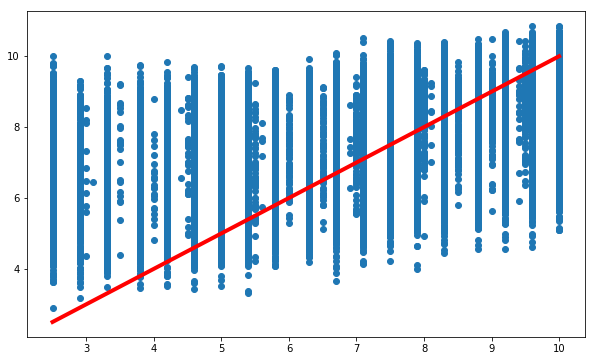

In [14]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    probability, hotels['Reviewer_Score'],random_state=27)

#sc = StandardScaler(with_mean=False)
#sparse_X_train = sc.fit_transform(sparse_X_train)
#sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**Classification XGB All Prob**

In [15]:
hotels['Reviewer_Score_class'] = (round(hotels['Reviewer_Score'])-2).astype(int)
hotels['Reviewer_Score_class'].unique()

array([1, 6, 5, 2, 3, 8, 4, 7, 0])

In [22]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    probability, hotels['Reviewer_Score_class'],random_state=27)

#XGB Classifier takes a very long time
#fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test,linear=False )

sgd_ovr = OneVsRestClassifier(SGDClassifier())
sgd_ovr.fit(sparse_X_train,sparse_Y_train)y_pred = sgd_ovr.predict(sparse_X_test)

accuracy_score(sparse_Y_test,y_pred)

0.4016597510373444